Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 2077.9542036862263
R-squared Score: 0.9315344750872342
Cross-Validation Mean MSE: 0.0028194500160171423


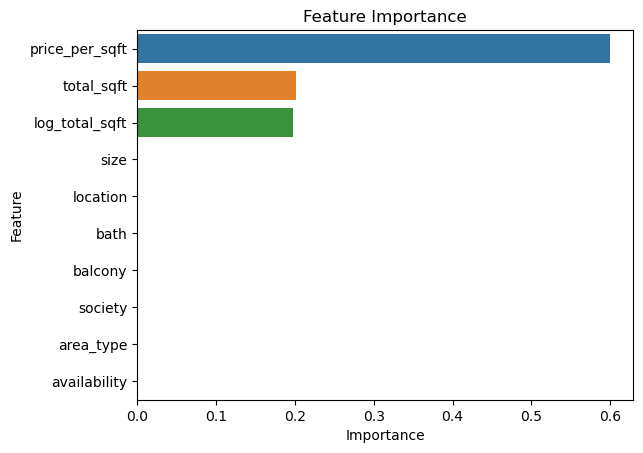

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"C:\Users\Indra\Downloads\Bengaluru_House_Data.csv"
data = pd.read_csv(file_path)

# Step 1: Data Cleaning
# Fill missing values
data['location'] = data['location'].fillna('Unknown')
data['size'] = data['size'].fillna(data['size'].mode()[0])
data['society'] = data['society'].fillna('Unknown')
data['bath'] = data['bath'].fillna(data['bath'].median())
data['balcony'] = data['balcony'].fillna(data['balcony'].median())

# Convert 'total_sqft' to a numeric value
def convert_sqft_to_num(sqft):
    try:
        if '-' in sqft:
            sqft_range = sqft.split('-')
            return (float(sqft_range[0]) + float(sqft_range[1])) / 2
        return float(sqft)
    except:
        return None

data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)

# Drop rows where 'total_sqft' is still missing
data = data.dropna(subset=['total_sqft'])

# Step 2: Feature Engineering
# Add a price per square foot feature
data['price_per_sqft'] = data['price'] / data['total_sqft']

# Log transformation for skewed features
data['log_price'] = np.log1p(data['price'])
data['log_total_sqft'] = np.log1p(data['total_sqft'])

# Label Encoding for categorical features
categorical_cols = ['area_type', 'availability', 'location', 'size', 'society']
encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = encoder.fit_transform(data[col])

# Step 3: Define Features and Target
X = data.drop(['price', 'log_price'], axis=1)  # Keep all columns except the original price
y = data['log_price']

# Step 4: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Scaling Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

# Step 7: Final Model Training
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)

# Step 8: Model Evaluation
y_pred = best_rf_model.predict(X_test_scaled)
mse = mean_squared_error(np.expm1(y_test), np.expm1(y_pred))
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Step 9: Cross-Validation
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validation Mean MSE: {-cv_scores.mean()}")

# Step 10: Feature Importance
importances = best_rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()
